In [35]:
import torch
import math
from SC_IPFP.torch.utils import NN, log_kde_pdf_per_point, silvermans_rule

In [36]:
torch.random

<module 'torch.random' from '/home/fav25/.local/lib/python3.6/site-packages/torch/random.py'>

In [71]:
def solve_sde_RK(alfa=None, beta=None, X0=None, dt=1.0, N=100, t0=0.0,
                theta=None, noise=False, forwards=True):
    """
            Euler Mayurama method
    Syntax:
    ----------
    solve_sde(alfa=None, beta=None, X0=None, dt=None, N=100, t0=0, DW=None)
    Parameters:
    ----------
        alfa  : a  function with two arguments, the X state and the time
                defines the differential equation.
        beta  : a  function with two arguments, the X state and the time
                defines the stochastic part of the SDE.
        X0    : Initial conditions of the SDE. Mandatory for SDEs
                with variables > 1 (default: gaussian np.random)
        dt    : The timestep of the solution
                (default: 1)
        N     : The number of timesteps (defines the length of the timeseries)
                (default: 100)
        t0    : The initial time of the solution
                (default: 0)
    
    """
    
#     print(X0)
       
    if alfa is None or beta is None:
        raise ValueError("Error: SDE not defined.")

    n, d, *_ = X0.shape
    
    T = torch.tensor(dt * N)
    
    DWs  = torch.empty((n, N-1, d)).normal_(mean=0, std=1)  * math.sqrt(dt)
    
    
    Y, ti = torch.zeros((n, N, d + 1)).double(), torch.arange(N).double()*dt + t0
    t0rep =  (
        t0 * torch.ones((X0.shape[0], 1)).double() if forwards
        else (T-t0) * torch.ones((X0.shape[0], 1)).double()
    )
#     Y[:, 0, :] =  torch.cat((X0, t0rep), axis=1 )
    ixs = torch.arange(3, dtype=torch.int64)
    Y = torch.cat((X0, t0rep), axis=1 )[:, None, :]

    N = int(N)
    
    T = dt * N
        
    for n in range(N-1):
        t = ti[n]
        a, DW_n = alfa(Y[:,n, :]),  DWs[:,n,:]
        newY = (  
            Y[:,n, :-1] + a * dt + beta * DW_n
        )
        
        trep = (
            t.repeat(newY.shape[0]).reshape(-1,1) if forwards
            else T - t.repeat(newY.shape[0]).reshape(-1,1)
        )
        
        tocat = torch.cat((newY, trep), dim=1)[:, None, :]
        Y = torch.cat((Y,tocat) , dim=1)
    
    return ti, Y

In [72]:
alpha = lambda x : torch.zeros(x.shape[1] -1).double()
beta = torch.tensor(1.0).double()

In [73]:
ti, Y = solve_sde_RK(alfa=alpha, beta=beta, X0 = torch.empty(50,1).normal_(0,1).double())

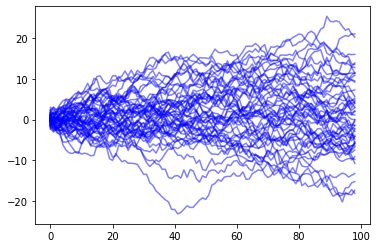

In [74]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot( Y[:,:, -1].numpy().T,  np.squeeze(Y[:,:, :-1].numpy()).T, alpha=0.5, color="blue");
plt.show()

In [77]:
nn = NN(input_dim=2, weight_dim_list=[20,20,20, 1]).double()

alpha = lambda x : nn.forward(x).double()


ti, Y = solve_sde_RK(alfa=alpha, beta=beta, X0 = torch.empty(50,1).normal_(0,1).double())

/auto/homes/fav25/SC-IPFP/SC_IPFP/torch/utils.py:73: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.layers[i].weight)


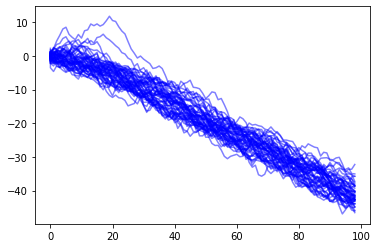

In [78]:

for i in range(Y.shape[0]):
    plt.plot( Y[i,:, -1].cpu().detach().numpy().flatten(),  np.squeeze(Y[i,:, :-1].cpu().detach().numpy()).flatten(), alpha=0.5, color="blue");
plt.show()